# Libraries and create tiles

In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys; import scanpy as sc
from pathlib import Path
from typing import Optional, Union
from anndata import AnnData
import pandas as pd
import stlearn
from typing import Optional, Union
from anndata import AnnData
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import numpy as np
import os
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import os
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score
from skimage.color import rgb2hed
%matplotlib inline
import pandas as pd
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import lime
from sklearn.preprocessing import MinMaxScaler
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
import glob
import os
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.preprocessing import OneHotEncoder
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
import scipy as sp
from scipy import ndimage as ndi
from skimage.morphology import area_opening
import math; import copy


def tiling(
        adata: AnnData,
        out_path: Union[Path, str] = "./tiling",
        library_id: str = None,
        crop_size: int = 40,
        target_size: int = 299,
        verbose: bool = False,
        copy: bool = False,
) -> Optional[AnnData]:
    

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
            total=len(adata),
            desc="Tiling image",
            bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            # tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile = tile.resize((target_size, target_size))
            tile_name = library_id + "-" + str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)#np.arange(len(pd.Series(adata))+1).astype(str).str.zfill(4)+1 + "-" +
            out_tile = Path(out_path) / (tile_name + ".jpeg")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "JPEG")

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None

# Loading Visium Data and Image Tilling

In [2]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img


SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

Sample1_un_norm, Sample2_un_norm = copy.copy(Sample1), copy.copy(Sample2)

for adata in [Sample1,Sample2,]:
    #Preprocessing
    st.pp.filter_genes(adata,min_cells=3)
    st.pp.log1p(adata)
    sc.pp.filter_cells(adata,min_counts=100)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    #tiling(adata, TILE_PATH_, crop_size=299)
    
    #st.pp.extract_feature(adata)
    
"""Sample1.obs.iloc[:,4:] #Link_to_img
Sample2.obs.iloc[:,4:] #Link_to_img

Sample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes 
Sample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes"""

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X
Log transformation step is finished in adata.X


'Sample1.obs.iloc[:,4:] #Link_to_img\nSample2.obs.iloc[:,4:] #Link_to_img\n\nSample1.to_df()[Sample1.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes \nSample2.to_df()[Sample2.to_df().sum().sort_values(ascending=False).index[:500]] #top-500-genes'

In [3]:
"""Sample1.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']].to_csv('Biomarker_Train.csv',index=False)
Sample2.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']].to_csv('Biomarker_Test.csv',index=False)"""
#pd.DataFrame(Sample1.obsm['X_tile_feature']).to_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample1A.csv')

"Sample1.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']].to_csv('Biomarker_Train.csv',index=False)\nSample2.to_df()[['COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1']].to_csv('Biomarker_Test.csv',index=False)"

# FFPE

In [3]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "FFPE_Breast_Cancer"
Sample3 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"Visium_FFPE_Human_Breast_Cancer_image.tif", 0)
Sample3.uns["spatial"][SAMPLE]['images']["fulres"] = img


Sample3_un_norm = copy.copy(Sample3)
for adata in [Sample3,]:
     
    #st.pp.normalize_total(adata)
    st.pp.filter_genes(adata,min_cells=3)
    sc.pp.filter_cells(adata,min_counts=100)
    st.pp.log1p(adata)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    tiling(adata, TILE_PATH_, crop_size=299)
    st.pp.extract_feature(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X


In [14]:
#pd.DataFrame(Sample3.obsm['X_tile_feature']).to_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample3_FFPE.csv')

# Model Training

In [50]:
from sklearn.multioutput import MultiOutputClassifier; import lightgbm as lgb
import pandas as pd; import shap; import numpy as np; import joblib
from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split

wd = "D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files"

biomarker_list_1 = ["TTLL12"]#, "FASN", "ACTG1", "HLA-B"] #'COX6C','MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1',"PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1"]

X_1 = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample1A.csv')
X_1 = X_1.iloc[:,1:]
test_X_1 = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample2A.csv')
test_X_1 = test_X_1.iloc[:,1:]


Y_1 = Sample1.to_df().reindex(Sample1.obs.sort_values("imagerow").index)
test_Y_1 = Sample2.to_df().reindex(Sample2.obs.sort_values("imagerow").index)
model_c = lgb.LGBMClassifier()#MLPClassifier(alpha=1, max_iter=7500)#
model_r = lgb.LGBMRegressor()
    
MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))

Y_1 = Y_1[biomarker_list_1]
Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
Y_1 = pd.DataFrame(data=Y_1)
#Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.33, 0.6, 1.01], labels = [0, 1, 2]))
Y_1 = Y_1.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))

test_Y_1 = test_Y_1[biomarker_list_1]
test_Y_1 = MinMax_scaler_y_1.transform(test_Y_1)
test_Y_1 = pd.DataFrame(data=test_Y_1)
#test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.33, 0.6, 1.01], labels = [0, 1, 2]))
test_Y_1 = test_Y_1.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))
test_Y_1 = test_Y_1.fillna(0)

Y_1 = Y_1.astype('int64')
test_Y_1 = test_Y_1.astype('int64')

In [51]:
Y_1_0 = Y_1[Y_1[0]==0]
Y_1_0_reg = Sample1.to_df().iloc[Y_1_0.index][biomarker_list_1]
X_1_0 = X_1.iloc[Y_1_0.index]

Y_1_1 = Y_1[Y_1[0]==1]
Y_1_1_reg = Sample1.to_df().iloc[Y_1_1.index][biomarker_list_1]
X_1_1 = X_1.iloc[Y_1_1.index]

In [52]:
clf_1 = model_c.fit(X_1, Y_1)#MultiOutputClassifier(model).fit(X_1, Y_1) #joblib.dump(clf, wd+'ResNet50-LGBM_biomarker_gene.pkl')
reg_0 = model_r.fit(X_1_0, Y_1_0_reg)
reg_1 = model_r.fit(X_1_1, Y_1_1_reg)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [53]:
GE = Sample2.to_df().reset_index(drop=True)
GE['C'] = clf_1.predict(test_X_1)

GE['f'] = GE.index.repeat(3yy)[:len(GE)]
GE['C_updated'] = GE.groupby(['f'])['C'].transform(lambda x: x.mode()[0])

GE_0 = GE[GE['C_updated']==0]
GE_1 = GE[GE['C_updated']==1]

test_X_1_0 = test_X_1.iloc[GE_0.index]
test_X_1_1 = test_X_1.iloc[GE_1.index]

r1 = reg_0.predict(test_X_1_0)
r2 = reg_1.predict(test_X_1_1)

In [54]:
Reg1 = pd.DataFrame(index = GE[GE['C_updated']==0].index)
Reg1["r"] = r1
Reg2 = pd.DataFrame(index = GE[GE['C_updated']==1].index)
Reg2["r"] = r2
Reg = pd.concat([Reg1,Reg2])
Reg = Reg.sort_index()
Reg.index = Sample2.to_df().reindex(Sample2.obs.sort_values("imagerow").index).index

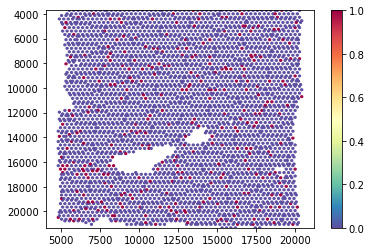

In [55]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample2.obs["imagerow"] 
y = Sample2.obs["imagecol"] 

c = GE['C_updated']

plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#INDIVIDUAL
#BUILDING REGRESSION ON REGRESSION

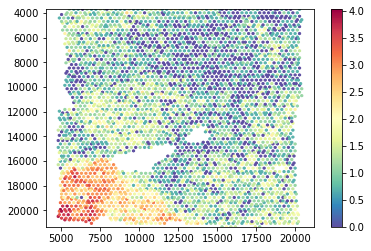

In [56]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample2.obs["imagerow"] 
y = Sample2.obs["imagecol"] 

c = Sample2.to_df()["TTLL12"]

plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#INDIVIDUAL
#BUILDING REGRESSION ON REGRESSION

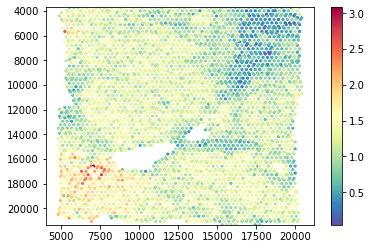

In [57]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample2.obs["imagerow"] 
y = Sample2.obs["imagecol"] 

c = Reg["r"]

plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#INDIVIDUAL
#BUILDING REGRESSION ON REGRESSION

In [ ]:
"""y_pred_test_1 = clf_1.predict_proba(test_X_1)
y_pred_test_1 = np.array(y_pred_test_1)"""

y_pred_test_2_1 = clf_1.predict(test_X_1)
y_pred_test_2_1 = pd.DataFrame(y_pred_test_2_1)

In [ ]:
auroc_1 = []
for col in test_Y_1:
    score_multi_1 = roc_auc_score(test_Y_1[col], y_pred_test_2_1[col])#, average='weighted'
    auroc_1.append(score_multi_1)
    
result_1 = pd.DataFrame()
result_1["auroc"] = auroc_1
result_1.index = biomarker_list_1
result_1

# Old Results

In [90]:
result_1.sort_values("auroc", ascending=False)

,auroc
HSP90AB1,0.742070
GNAS,0.721810
PABPC1,0.721642
COX6C,0.714503
FASN,0.688059
ACTG1,0.671417
TFF3,0.643042
HLA-B,0.616278
ATP1A1,0.605532
B2M,0.579554
